# IAAIP 2022 - Synthetic Data Generation using Variational Autoencoders
*Lecturer: Simon H. Tindemans*

*Assistant: Kutay Bölat*

This notebook is dedicated to give a better understanding what has been lectured in TU Delft IAAIP 2022 - Synhetic Data Generation using Variational Autoencoders (VAEs) tutorial. It allows users of it to play with different configurations and observe the visualized results. 

The GitHub repository of the notebook will be functioning. If you experience any issues or contribute to the code, feel free to open an Issue or request a Push.

Import Libs

In [1]:
%matplotlib inline

import torch
import matplotlib.pyplot as plt
import matplotlib
import requests
import os
import zipfile
import pandas as pd
from tqdm.notebook import tqdm
from numpy import isnan
from datetime import timedelta

Download Data

In [2]:
if not os.path.exists('data/electricity.zip'):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
    response = requests.get(url, allow_redirects=True)

    with open("data/electricity.zip","wb") as handle:
        for data in tqdm(response.iter_content()):
            handle.write(data)

    with zipfile.ZipFile("data/electricity.zip",'r') as zip_ref:
        zip_ref.extractall("data")

    os.rename('data/household_power_consumption.txt','data/household_power_consumption.csv')


Preprocess Data

In [2]:
resolution = 60
feature_dim = 24*60//resolution
df_raw = pd.read_csv('data/household_power_consumption.csv', sep=';', index_col=False, low_memory=False, na_values='?')
df_raw = df_raw.iloc[21996::resolution,[0,1,2]]
df_raw['datetime'] = pd.to_datetime(df_raw['Date']+' '+df_raw['Time'], infer_datetime_format=True, dayfirst=True)
df_raw = df_raw.drop(['Date','Time'],axis=1)
df_raw = df_raw.set_index(['datetime'])

In [3]:
g = df_raw.groupby(df_raw.index.floor('d'))

daily_data = []
my_day, final_day = df_raw.index[0].date(), df_raw.index[-1].date()

while my_day < final_day:
    try:
        day_data = g.get_group(my_day).T.values.tolist()[0]
    except:
        print("Date "+str(my_day)+" is missing.")
        my_day += timedelta(days=1)
    else:
        if (not isnan(day_data).any()) and day_data.__len__() == feature_dim:
            row_data = [my_day.month, my_day.weekday()] + day_data
            daily_data.append(row_data)
        my_day += timedelta(days=1)

print('Dataset Size:'+str(daily_data.__len__()))



Dataset Size:1396


In [4]:
column_names = ['month', 'weekday']
my_day = pd.Timestamp('2012-01-01')
for _ in range(feature_dim):
    column_names.append(my_day.strftime('%H:%M'))
    my_day+=timedelta(minutes=resolution)

# %%
df_daily = pd.DataFrame(daily_data,columns=column_names)
df_daily.to_csv('data/daily_data.csv',index=False)

Split Dataset

In [5]:
from sklearn.model_selection import train_test_split
train_ratio = 0.8
df_train, df_test = train_test_split(df_daily, train_size=train_ratio)

DataLoader

In [6]:
class ElectricityData(torch.utils.data.Dataset):
    def __init__(self, df):
        data = torch.tensor(df.values).float()
        self.inputs = data[:,2:]
        self.mean = self.inputs.mean(dim=0)
        self.std = self.inputs.std(dim=0)
        self.inputs = (self.inputs-self.mean)/self.std
        
        self.int_conditions = data[:,[[0],[1]]]
        self.conditions = self.circlize(self.int_conditions)

    def circlize(self,condition):
        max_conds = torch.max(condition,dim=0,keepdim=False)[0]
        min_conds = torch.min(condition,dim=0,keepdim=False)[0]
        return torch.cat((torch.cos((condition-min_conds)/(max_conds-min_conds+1)*2*torch.pi),torch.sin((condition-min_conds)/(max_conds-min_conds+1)*2*torch.pi)),dim=2).reshape(condition.shape[0],-1)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return self.inputs[idx], self.conditions[idx]


Neural Networks

In [7]:
NUM_NEURONS = 50
ACTIVATION = torch.nn.CELU(inplace=True)

class Encoder(torch.nn.Module):
    def __init__(self,input_dim,latent_dim):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.fc1 = torch.nn.Linear(input_dim, NUM_NEURONS)
        self.fc2 = torch.nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc3 = torch.nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc_mean = torch.nn.Linear(NUM_NEURONS, latent_dim)
        self.fc_sigmatilde = torch.nn.Linear(NUM_NEURONS, latent_dim)

        # setup the non-linearity
        self.act = ACTIVATION

    def forward(self, x):
        h = x.view(-1, self.input_dim)
        h = self.act(self.fc1(h))
        h = self.act(self.fc2(h))
        h = self.act(self.fc3(h))
        z_mean = self.fc_mean(h)
        z_sigmatilde = self.fc_sigmatilde(h)
        return z_mean, z_sigmatilde

    def _num_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class Decoder(torch.nn.Module):
    def __init__(self,output_dim,latent_dim,learn_sigma=False):
        super(Decoder, self).__init__()
        self.input_dim = output_dim
        self.latent_dim = latent_dim
        self.learn_sigma = learn_sigma

        self.fc1 = torch.nn.Linear(latent_dim, NUM_NEURONS)
        self.fc2 = torch.nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc3 = torch.nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc_mean = torch.nn.Linear(NUM_NEURONS, output_dim)
        if learn_sigma: self.fc_sigmatilde = torch.nn.Linear(NUM_NEURONS, output_dim)

        # setup the non-linearity
        self.act = ACTIVATION

    def forward(self, z):
        h = z.view(-1, self.latent_dim)
        h = self.act(self.fc1(h))
        h = self.act(self.fc2(h))
        h = self.act(self.fc3(h))
        x_mean = self.fc_mean(h)
        if self.learn_sigma:
            x_sigmatilde = self.fc_sigmatilde(h)
        else:
            x_sigmatilde = 0.0*x_mean
        return x_mean, x_sigmatilde

    def _num_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

VAE Models

In [8]:
class VAE(torch.nn.Module):
    def __init__(self,input_dim=24, cond_dim=4, latent_dim=10, learn_sigma=True):
        super(VAE, self).__init__()
        
        self.input_dim, self.cond_dim, self.latent_dim = input_dim, cond_dim, latent_dim

        self.encoder = Encoder(self.input_dim+self.cond_dim, self.latent_dim)
        self.decoder = Decoder(self.input_dim, self.latent_dim+self.cond_dim, learn_sigma)
        
        self.num_parameters = self.encoder._num_parameters()+self.decoder._num_parameters()
    
    def forward(self,inputs,conditions):
        z_mean, z_sigmatilde = self.encoder(torch.cat((inputs,conditions),dim=1))
        z = self.sample(z_mean, z_sigmatilde)
        x_mean, x_sigmatilde = self.decoder(torch.cat((z,conditions),dim=1))
        return {"mean": x_mean, "sigmatilde": x_sigmatilde}, {"mean": z_mean, "sigmatilde": z_sigmatilde, "sample": z} 

    def sample(self,mean,sigmatilde):
        eps = torch.randn(mean.shape)
        return mean + eps*self.to_sigma(sigmatilde)

    def reconstruction_loglikelihood(self, input, mean, sigmatilde):
        sigma = self.to_sigma(sigmatilde)
        return (-.5*(torch.tensor(2)*torch.pi).log()-sigma.log()-.5*((input-mean)/sigma).pow(2)).sum(dim=1)

    def kl_divergence(self, mean_posterior, sigmatilde_posterior, mean_prior=None, sigmatilde_prior=None):
        if mean_prior is None: mean_prior = mean_posterior*0.0
        if sigmatilde_prior is None: sigmatilde_prior =  self.from_sigma(sigmatilde_posterior*0.0 + 1.0)

        sigma_posterior = self.to_sigma(sigmatilde_posterior)
        sigma_prior = self.to_sigma(sigmatilde_prior)

        return .5*((sigma_posterior/sigma_prior).pow(2) + ((mean_posterior-mean_prior)/sigma_prior).pow(2) -1 + 2*(sigma_prior.log()-sigma_posterior.log())).sum(dim=1)
    
    def loss(self, input, x_mean, x_sigmatilde, z_mean, z_sigmatilde, beta=1):
        rll = self.reconstruction_loglikelihood(input,x_mean,x_sigmatilde).mean(dim=0)
        kl = self.kl_divergence(z_mean,z_sigmatilde).mean(dim=0)
        return {"loss":-(rll-beta*kl), "elbo": rll-kl, "rll": rll, "kl": kl}

    def to_sigma(self,sigmatilde):
        return torch.log2(1+torch.pow(torch.tensor(2),sigmatilde))

    def from_sigma(self,sigma):
        return torch.log2(torch.pow(torch.tensor(2),sigma)-1)

Training Settings

In [32]:
batch_size = 64
epochs = 1000
beta = 1
learning_rate = 1e-3
latent_dim = 10
verbose_freq = 500
cond_idx = []

Training Loop

In [33]:
dset = ElectricityData(df_train)
train_loader = torch.utils.data.DataLoader(dset,batch_size=batch_size,shuffle=True,drop_last=True)
model = VAE(input_dim=feature_dim, cond_dim=2*len(cond_idx), latent_dim=latent_dim, learn_sigma=False)

In [34]:
pbar = tqdm(total=(dset.__len__()//batch_size) * epochs)

optim = torch.optim.Adam([{'params':model.encoder.parameters()},
                        {'params':model.decoder.parameters()}],lr=learning_rate)

epx = 0
itx = 0
idx_map = [[0,1],[2,3]]
idx = sum([idx_map[i] for i in cond_idx],[])

for _ in range(epochs):
    epx += 1
    for inputs, conditions in train_loader:
        itx += 1
        pbar.update(1)
        x_dict, z_dict = model.forward(inputs, conditions[:,idx])

        optim.zero_grad()
        loss = model.loss(inputs,x_dict["mean"],x_dict["sigmatilde"],z_dict["mean"],z_dict["sigmatilde"],beta=beta)
        loss["loss"].backward()
        optim.step()

        if itx%verbose_freq==0: 
            pbar.write(f"Iteration: {itx} -- ELBO={loss['elbo'].item():.4f} / RLL={loss['rll'].item():.4f} / KL={loss['kl'].item():.4f}")
            pbar.write(f"Min_sigmatilde: {x_dict['sigmatilde'].min().item()}")


  0%|          | 0/17000 [00:00<?, ?it/s]

Iteration: 500 -- ELBO=-31.1795 / RLL=-29.7273 / KL=1.4522
Min_sigmatilde: 0.0
Iteration: 1000 -- ELBO=-30.9005 / RLL=-29.3467 / KL=1.5539
Min_sigmatilde: 0.0
Iteration: 1500 -- ELBO=-31.9448 / RLL=-30.0656 / KL=1.8792
Min_sigmatilde: -0.0
Iteration: 2000 -- ELBO=-31.8654 / RLL=-30.0667 / KL=1.7987
Min_sigmatilde: -0.0
Iteration: 2500 -- ELBO=-31.2162 / RLL=-29.3252 / KL=1.8910
Min_sigmatilde: -0.0
Iteration: 3000 -- ELBO=-32.0868 / RLL=-30.0028 / KL=2.0840
Min_sigmatilde: -0.0
Iteration: 3500 -- ELBO=-33.1025 / RLL=-31.0566 / KL=2.0458
Min_sigmatilde: 0.0
Iteration: 4000 -- ELBO=-30.5469 / RLL=-28.9331 / KL=1.6137
Min_sigmatilde: 0.0
Iteration: 4500 -- ELBO=-31.1629 / RLL=-29.3146 / KL=1.8483
Min_sigmatilde: -0.0
Iteration: 5000 -- ELBO=-30.7186 / RLL=-28.9405 / KL=1.7782
Min_sigmatilde: -0.0
Iteration: 5500 -- ELBO=-32.0275 / RLL=-30.1185 / KL=1.9090
Min_sigmatilde: -0.0
Iteration: 6000 -- ELBO=-30.6632 / RLL=-28.8561 / KL=1.8071
Min_sigmatilde: 0.0
Iteration: 6500 -- ELBO=-32.0657 /

Sample Visualization

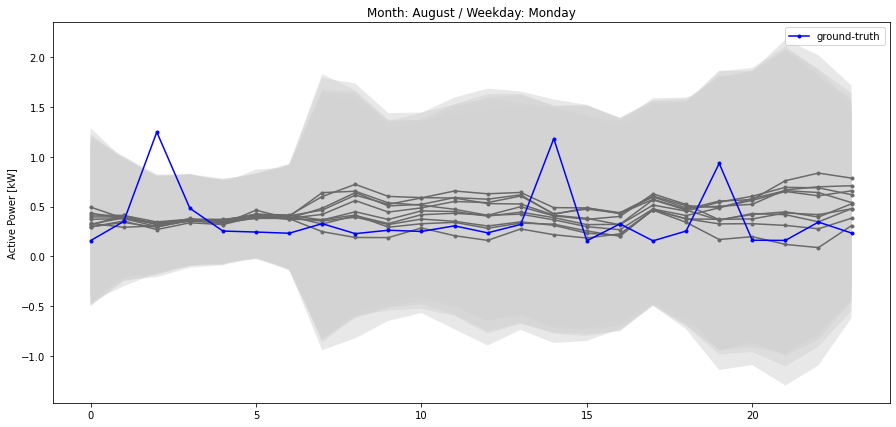

In [35]:
import calendar
rnd_idx = torch.randint(high=dset.__len__(),size=(1,))
real_sample = dset.inputs[rnd_idx]
month = calendar.month_name[dset.int_conditions[rnd_idx].squeeze()[0].int().item()]
weekday = calendar.day_name[dset.int_conditions[rnd_idx].squeeze()[1].int().item()]
cond = dset.conditions[rnd_idx,idx]
num_mc_samples = 10

with torch.no_grad():
    fig, ax = plt.subplots(clear=True, figsize= (15,7))
    z_mean, z_sigmatilde = model.encoder(torch.cat((real_sample,cond),dim=1))
    z_real_sample = z_mean
    ax.set_ylabel("Active Power [kW]")
    ax.set_title(f"Month: {month} / Weekday: {weekday}")
    z_samples = torch.tensor([])
    for m in range(num_mc_samples):
        z = model.sample(z_mean, z_sigmatilde)
        z_samples = torch.concat((z,z_samples))
        x_mean, x_sigmatilde = model.decoder(torch.cat((z,cond),dim=1))
        x_sigma = model.to_sigma(x_sigmatilde)
        x_mean = x_mean*dset.std+dset.mean
        x_sigma = x_sigma*dset.std

        ax.fill_between(list(range(feature_dim)),(x_mean+x_sigma).squeeze().numpy(), (x_mean-x_sigma).squeeze().numpy(), facecolor='lightgrey', alpha=0.5)
        ax.plot(x_mean.squeeze().numpy(), color='dimgrey', marker='.')
    ax.plot((real_sample.squeeze()*dset.std+dset.mean).numpy(), color='b', marker='.', label='ground-truth')
    ax.legend()

Latent Visualization

In [36]:
with torch.no_grad():
    x_dict, z_dict = model.forward(dset.inputs, dset.conditions[:,idx])

z_mean = z_dict['mean']
z_sigma = model.to_sigma(z_dict['sigmatilde'])
angle = 0
if latent_dim >= 2:
    z_mean -= z_mean.mean(dim=0)
    U,S,Vh = torch.linalg.svd(z_mean,full_matrices=False)
    z_mean = (z_mean @ Vh.t())[:,:2]
    z_Sigma = (Vh.t() @ z_sigma.square().diag_embed() @ Vh)[:,:2,:2]
    z_sigma = torch.linalg.eig(z_Sigma)[0].real.sqrt()
    eig_vectors = torch.linalg.eig(z_Sigma)[1][:,:,0].real
    angle = torch.atan2(Vh[0,1],Vh[0,0]).numpy() * 180/torch.pi

    # z_samples_tr = (z_samples @ Vh.t())[:,:2]
    # z_real_sample_tr = (z_real_sample @ Vh.t())[:,:2]

z_mean = z_mean.numpy()
z_sigma = z_sigma.numpy()

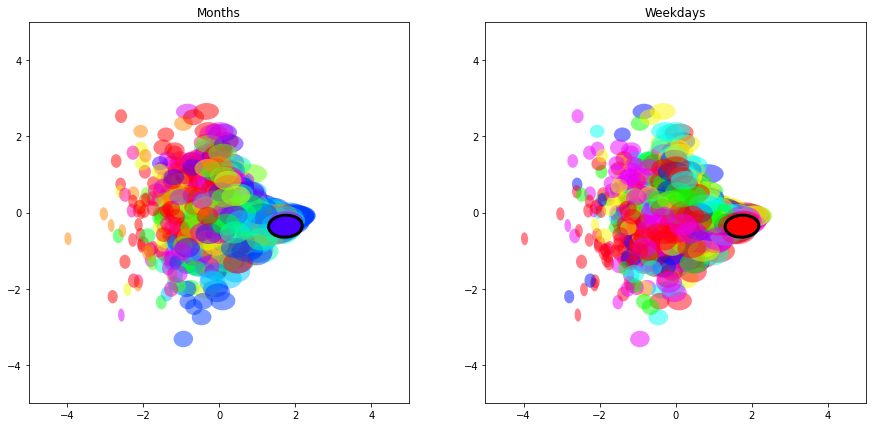

In [37]:
from cProfile import label


fig, axs = plt.subplots(1,2,figsize=(15,7))

weekday_cmap = plt.get_cmap('hsv',7)
# weekday_cmap = [weekday_cmap(i) for i in range(weekday_cmap.N)]
month_cmap = plt.get_cmap('hsv',12)
# month_cmap = [month_cmap(i) for i in range(month_cmap.N)]

for x,y,s1,s2, cond in zip(z_mean[:,0],z_mean[:,1],z_sigma[:,0],z_sigma[:,1], dset.int_conditions.squeeze().numpy()):
    ell = matplotlib.patches.Ellipse((x,y), s1, s2, angle=angle, alpha=.5)
    ell.set_facecolor(month_cmap(int(cond[0]-1)))
    axs[0].add_artist(ell)
    ell = matplotlib.patches.Ellipse((x,y), s1, s2, angle=angle, alpha=.5)
    ell.set_facecolor(weekday_cmap(int(cond[1])))
    axs[1].add_artist(ell)

for i, (ax, cmap) in enumerate(zip(axs,[month_cmap,weekday_cmap])):
    ell = matplotlib.patches.Ellipse((z_mean[rnd_idx,0],z_mean[rnd_idx,1]), z_sigma[rnd_idx,0], z_sigma[rnd_idx,1], angle=angle, alpha=1, lw=3)
    ell.set_edgecolor('k')
    ell.set_facecolor(cmap(dset.int_conditions[rnd_idx].squeeze()[i].int().item()))
    ax.add_artist(ell)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

axs[0].set_title("Months")
axs[1].set_title("Weekdays")
plt.show()
